### Import packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import re
import matplotlib.pyplot as plt
%matplotlib inline
from google.cloud import bigquery
from google.cloud import bigquery_storage
from sklearn.linear_model import LinearRegression
from datetime import datetime
import warnings
warnings.filterwarnings(action="ignore")

### User-defined global inputs

In [2]:
billing_project = "logistics-customer-staging" # The project that is displayed at the top of your BQ console
dataset = "cl" # For Global teams, use "cl". For local and regional teams, use "curated_data_shared"

# Entity of choice
entities_of_choice = ["FP_TW"] # Choose the entity ID(s) that have the tests you want to analyze

# You can define a custom test list here. If you don't, the script will analyze ALL AB tests in the country of choice with the word elasticity in them.
is_use_defined_test_names = True # Set to True if you want to use the custom test list below

# Define the custom tests you want to analyze here
# This list will be used if "is_use_defined_test_names" = True. Otherwise, the script will analyze all tests with the keywords in "test_keyword_list" below
custom_test_list = ["20230926_TW_R_Elasticity_Taipei"]

# Test keywords
test_keyword_list = ["elasticity", "customer_location"] # If "is_use_defined_test_names" = False, the script will analyze all tests with these keywords in the test name

# Define whether you want to use GADM level 2 or 3
# You need to examine the GADM level 2 and 3 using the gadm_data_visualizer.ipynb notebook to decide which one to use
gadm_level = 2 # Typically, the default level is 2. However, we sometimes need to use level 3 if level 2 is not granular enough

# Define the type of area you want to consider
# For some countries, level two/three GADM data contains several types (e.g., Municipality, District, etc.).
# Examine the the BQ tables `gadm_geo_spatial_data_level_2` and `gadm_geo_spatial_data_level_3` and use the GADM data visualizer to determine which type of area you want to use
area_types = ["All"] # You can either select "All" or define specific area types (e.g., ["County", "District", "Municipality"] and so on)

# Grouping method
# We will use two grouping methods, "pct_ranks" and "avg"
# For the "pct_ranks" method, you need to specify the number of percentile ranks you want to use
# For the "avg" method, you need to define the *min* and *max* thresholds
    # Areas with a slope below the *min* threshold x avg slope of all areas would be labeled as "low elasticity" areas
    # Areas with a slope above the *max* threshold x avg slope of all areas would be labeled as "high elasticity" areas
    # Areas with slopes between *min* threshold x avg slope and *max* threshold x avg slope would be labeled as "mid elasticity" areas
num_groups = 3 # Only applicable for the "pct_ranks" grouping_method. Please use only 2, 3 or 5 groups. Otherwise, the categorisation (low, mid, high) will be difficult to compute
slope_lower_threshold = 0.8 # Only applicable for the "avg" grouping method. Areas with a slope of (1 - slope_lower_threshold)% below average would be labeled as "low elasticity" areas
slope_upper_threshold = 1.2 # Only applicable for the "avg" grouping method. Areas with a slope (slope_upper_threshold - 1)% above average would be labeled as "high elasticity" areas

#############################################################################################################################################  
**<center>#--------STARTING HERE, YOU DON'T NEED TO DEFINE ANY OTHER INPUTS--------#</center>**  
#############################################################################################################################################

### Create categories based on the value of num_groups

In [3]:
if num_groups == 2:
    pct_ranks_groups = ["low_price_sensitivity", "high_price_sensitivity"]
elif num_groups == 3:
    pct_ranks_groups = ["low_price_sensitivity", "mid_price_sensitivity", "high_price_sensitivity"]
elif num_groups == 5:
    pct_ranks_groups = ["very_low_price_sensitivity", "low_price_sensitivity", "mid_price_sensitivity", "high_price_sensitivity", "very_high_price_sensitivity"]

### Instantiate a BQ client

In [4]:
client = bigquery.Client(project=billing_project)
bqstorage_client = bigquery_storage.BigQueryReadClient()

### Pull the names of the elasticity tests

In [5]:
test_name_query = """
    SELECT DISTINCT
        entity_id,
        test_name,
        test_id,
        test_start_date,
        test_end_date,
        experiment_type
    FROM `fulfillment-dwh-production.{dataset}.dps_experiment_setups`
    WHERE LOWER(experiment_type) = "ab" AND entity_id IN ("{entities_of_choice}")
    ORDER BY test_end_date DESC
""".format(
    dataset=dataset,
    entities_of_choice='", "'.join(entities_of_choice)
)

df_test_names = pd.DataFrame(client.query(query=test_name_query).result().to_dataframe(progress_bar_type="tqdm", bqstorage_client=bqstorage_client))

# If is_use_defined_test_names == True, overwrite list_test_names with the custom_test_list. If it is False, filter the test names by the test_keyword_list
if is_use_defined_test_names == True:
    df_test_names = df_test_names[df_test_names["test_name"].isin(custom_test_list)]
else:
    df_test_names = df_test_names[df_test_names["test_name"].str.contains("|".join(test_keyword_list), case=False)]

# Create a list of test names out of df_test_names
list_test_names = df_test_names["test_name"].tolist()
list_test_ids = df_test_names["test_id"].tolist()

# Define the lookback window for the analysis based on the minimum test start date
lookback_period_start_date = datetime.strftime(df_test_names["test_start_date"].min().date(), "%Y-%m-%d")
try:
    lookback_period_end_date = datetime.strftime(df_test_names["test_end_date"].max().date(), "%Y-%m-%d")
except ValueError:
    # If the test is still running, the test_end_date will be null. In this case, we will use today's date as the end date
    lookback_period_end_date = datetime.strftime(datetime.today().date(), "%Y-%m-%d")

Downloading: 100%|██████████|


### Pull the test data

In [7]:
test_data_query = """
	-- Get the GADM data for the countries of choice
	WITH gadm_data AS (
		SELECT 
			ent.segment AS region,
			ent.global_entity_id AS entity_id,
			gadm.*
		FROM `logistics-data-storage-staging.long_term_pricing.gadm_geo_spatial_data_level_{gadm_level}` gadm
		LEFT JOIN `fulfillment-dwh-production.curated_data_shared_coredata.global_entities` ent ON gadm.gid_0 = ent.country_iso_a3
		WHERE TRUE
			AND IF ("{area_types}" = "All", TRUE, gadm.engtype_{gadm_level} IN ("{area_types}"))
			AND ent.is_reporting_enabled
            AND ent.is_entity_online
            AND ent.global_entity_id IN ("{entities_of_choice}")
            AND ent.brand_name IN (
				"Foodpanda",
				"Baemin",
				"Talabat",
				"Yemeksepeti",
				"HungerStation",
				"eFood",
				"Foodora",
				"PedidosYa"
			)
	),
    
    -- Get the perseus location of each perseus session ID for the tests of choice
    perseus_location AS (
		SELECT
			x.entity_id,
			x.perseus_session_id,
			x.perseus_location
		FROM `fulfillment-dwh-production.{dataset}.dps_sessions_mapped_to_perseus_sessions` x
		LEFT JOIN UNNEST(events) AS e
		LEFT JOIN `fulfillment-dwh-production.{dataset}.dps_experiment_setups` tst ON x.entity_id = tst.entity_id AND x.sessions.experiment_id = tst.test_id
		WHERE TRUE
			AND x.created_date BETWEEN DATE("{lookback_period_start_date}") AND DATE("{lookback_period_end_date}") -- Filter for the right lookback window
			AND tst.test_name IN ("{test_names}") -- Filter for the right tests
			AND x.sessions.variant != "Original" -- Exclude orders from ASAs
			AND e.vertical_parent_in_test = TRUE -- Only include sessions that have the same parent vertical as the one configured in the test
		QUALIFY ROW_NUMBER() OVER (PARTITION BY x.entity_id, x.perseus_session_id ORDER BY e.event_time DESC) = 1 -- Get the latest location for every session
	),
    
    -- Enrich the perseus location data with the GADM data
    perseus_location_enriched AS (
		SELECT
			x.*,
			gadm.geometry AS admin_area_geometry,
			gadm.name_2 AS admin_area_name
		FROM perseus_location x
        -- This LEFT JOIN checks if the customer location is contained within an admin area and returns TRUE if that is the case
		LEFT JOIN gadm_data gadm ON x.entity_id = gadm.entity_id AND ST_CONTAINS(SAFE.ST_GEOGFROM(gadm.geometry), x.perseus_location)
    ),

    -- Calculate CVR and CVR3 for each test-area-variant combination
    cvr_agg_data AS (
		SELECT
			ent.segment AS region,
			x.entity_id,
			x.test_name,
			loc.admin_area_geometry,
			loc.admin_area_name,
			x.variant AS test_variant,
			COUNT(DISTINCT x.fe_session_id) AS total_session_count,
			COALESCE(ROUND(COUNT(DISTINCT x.transaction_no) / NULLIF(COUNT(DISTINCT x.fe_session_id), 0), 5), 0) AS cvr,
			COALESCE(ROUND(COUNT(DISTINCT x.transaction_no) / NULLIF(COUNT(DISTINCT x.shop_menu_no), 0), 5), 0) AS cvr3
		FROM `fulfillment-dwh-production.{dataset}.dps_test_cvr_treatment` x
		LEFT JOIN perseus_location_enriched loc ON x.entity_id = loc.entity_id AND x.fe_session_id = loc.perseus_session_id
		INNER JOIN `fulfillment-dwh-production.curated_data_shared_coredata.global_entities` ent ON x.entity_id = ent.global_entity_id -- Get the region associated with every entity_id
		WHERE TRUE
			AND x.created_date BETWEEN DATE("{lookback_period_start_date}") AND DATE("{lookback_period_end_date}") -- Filter for the right lookback window
			AND x.test_name IN ("{test_names}") -- Filter for the right tests
			AND x.variant != "Original" -- Exclude orders from ASAs
			AND x.vertical_parent_in_test = TRUE -- Only include sessions that have the same parent vertical as the one configured in the test
		GROUP BY 1, 2, 3, 4, 5, 6
    ),
    
    -- Calculate the avg DF for each test-area-variant combination
    orders_agg_data AS (
		SELECT
        	ent.segment AS region,
			a.entity_id,
			b.test_name,
            gadm.geometry AS admin_area_geometry,
  			gadm.name_2 AS admin_area_name,
			a.test_variant,
            AVG(a.delivery_fee_local) AS avg_df_local,
		FROM `fulfillment-dwh-production.{dataset}.dps_sessions_mapped_to_orders` a
		LEFT JOIN `fulfillment-dwh-production.{dataset}.dps_test_orders` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
        -- This LEFT JOIN checks if the customer location is contained within an admin area and returns TRUE if that is the case
		LEFT JOIN gadm_data gadm ON a.entity_id = gadm.entity_id AND ST_CONTAINS(SAFE.ST_GEOGFROM(gadm.geometry), a.customer_location)
        INNER JOIN `fulfillment-dwh-production.curated_data_shared_coredata.global_entities` ent ON a.entity_id = ent.global_entity_id -- Get the region associated with every entity_id
		WHERE TRUE
			AND a.created_date BETWEEN DATE("{lookback_period_start_date}") AND DATE("{lookback_period_end_date}")
			AND b.test_name IN ("{test_names}")
			AND a.is_own_delivery -- OD orders only
			AND a.test_variant != "Original" -- Exclude orders from ASAs
			AND a.is_match_test_vertical
		GROUP BY 1, 2, 3, 4, 5, 6
    )
    
    -- Join the CVR and order tables
    SELECT
		cvr.region,
		cvr.entity_id,
		cvr.test_name,
        cvr.admin_area_geometry,
        cvr.admin_area_name,
		cvr.test_variant,
		cvr.total_session_count,
		cvr.cvr,
		cvr.cvr3,
		ord.avg_df_local
	FROM cvr_agg_data cvr
	-- We use an INNER JOIN because we only want to include areas that have both CVR and order data
    INNER JOIN orders_agg_data ord USING(entity_id, test_name, admin_area_geometry, admin_area_name, test_variant)
	ORDER BY 1, 2, 3, 4
""".format(
	area_types='", "'.join(area_types),
	gadm_level=gadm_level,
    dataset=dataset,
    lookback_period_start_date=lookback_period_start_date,
    lookback_period_end_date=lookback_period_end_date,
    entities_of_choice='", "'.join(entities_of_choice),
    test_names = '", "'.join(list_test_names)
)

df_test_data = pd.DataFrame(client.query(query=test_data_query).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm"))\
    .sort_values(by=["region", "entity_id", "test_name", "admin_area_name", "test_variant"])\
    .reset_index(drop=True)

# Print the length of the data frame
print(f"The length of the data frame is: {len(df_test_data)}")

# Display the head of df_test_data
df_test_data.head(10)

Downloading: 100%|██████████|
The length of the data frame is: 12


,region,entity_id,test_name,admin_area_geometry,admin_area_name,test_variant,total_session_count,cvr,cvr3,avg_df_local
0,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Control,519,0.12717,0.35676,19.142857143
1,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Variation1,551,0.20690,0.51351,10.407407407
2,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Variation2,503,0.12127,0.36747,14.807692308
3,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.7078790600001 25.174400054...,New Taipei,Control,180270,0.39192,0.50950,15.839422850
4,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.7078790600001 25.174400054...,New Taipei,Variation1,182293,0.39842,0.51582,13.938987969
5,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.7078790600001 25.174400054...,New Taipei,Variation2,180046,0.38778,0.50627,17.198912756
6,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,POLYGON ((121.42069222200018 25.17597189500003...,Taipei,Control,135598,0.38664,0.49999,12.549460021
7,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,POLYGON ((121.42069222200018 25.17597189500003...,Taipei,Variation1,134431,0.39141,0.50719,11.665274633
8,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,POLYGON ((121.42069222200018 25.17597189500003...,Taipei,Variation2,134304,0.38388,0.49927,13.601052125
9,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,POLYGON ((121.28485870400004 25.11763954200006...,Taoyuan,Control,10000,0.32220,0.46127,17.940821603


### Calculate the slope of the linear regression line of CVR Vs. Avg DF per test-area combination

In [8]:
# Change the data types of the columns
df_test_data.loc[:, "total_session_count":] = df_test_data.loc[:, "total_session_count":].apply(lambda x: pd.to_numeric(x))

# Calculate the *absolute change in CVR* and the *percentage change in avg DF* between each variant and the control group
df_test_data_enriched = df_test_data.copy()

# Calculate the absolute change in CVR
df_test_data_enriched[["abs_cvr_change", "abs_cvr3_change"]] = df_test_data_enriched.\
    groupby(["region", "entity_id", "test_name", "admin_area_name"])[["cvr", "cvr3"]].\
    transform(lambda x: x - x.iloc[0])

# Calculate the percentage change in avg DF
df_test_data_enriched["pct_avg_df_change"] = df_test_data_enriched.\
    groupby(["region", "entity_id", "test_name", "admin_area_name"])["avg_df_local"].\
    transform(lambda x: (x - x.iloc[0]) / x.iloc[0])

# Display the head of the data frame
df_test_data_enriched.head()

,region,entity_id,test_name,admin_area_geometry,admin_area_name,test_variant,total_session_count,cvr,cvr3,avg_df_local,abs_cvr_change,abs_cvr3_change,pct_avg_df_change
0,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Control,519,0.12717,0.35676,19.142857,0.00000,0.00000,0.0
1,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Variation1,551,0.20690,0.51351,10.407407,0.07973,0.15675,-0.456329
2,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Variation2,503,0.12127,0.36747,14.807692,-0.00590,0.01071,-0.226464
3,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.7078790600001 25.174400054...,New Taipei,Control,180270,0.39192,0.50950,15.839423,0.00000,0.00000,0.0
4,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.7078790600001 25.174400054...,New Taipei,Variation1,182293,0.39842,0.51582,13.938988,0.00650,0.00632,-0.119981


In [9]:
# Create a function that regresses a variable "X" on another variable "y"
def reg_model(df, cvr_col, df_col):
    data_x = df[[df_col]].values
    data_y = df[[cvr_col]].values
    lm = LinearRegression()
    lm.fit(X=data_x, y=data_y)
    return float(np.squeeze(lm.coef_))

In [10]:
# Calculate the slope of the linear regression between the absolute change in CVR and the percentage change in avg DF per test-area combination
df_slopes = pd.DataFrame(
    df_test_data_enriched.\
        groupby(["region", "entity_id", "test_name", "admin_area_name"]).\
        apply(reg_model, cvr_col="abs_cvr_change", df_col="pct_avg_df_change"),
    columns=["reg_slope_per_test_area"]
    )

# Reset the index to flatten the data frame
df_slopes.reset_index(inplace=True)

# Join df_slopes to df_test_data_enriched
df_test_data_enriched = df_test_data_enriched.merge(
    df_slopes,
    how="left",
    on=["region", "entity_id", "test_name", "admin_area_name"]
)

# Display the df_slopes data frame
print("The head of the 'df_slopes' data frame is:")
display(df_slopes.head())

# Display the head of the data frame
print("The head of the 'df_test_data_enriched' data frame is:")
display(df_test_data_enriched.head())

The head of the 'df_slopes' data frame is:


,region,entity_id,test_name,admin_area_name,reg_slope_per_test_area
0,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,Keelung,-0.175215
1,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,New Taipei,-0.051856
2,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,Taipei,-0.048320
3,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,Taoyuan,-0.046398


The head of the 'df_test_data_enriched' data frame is:


,region,entity_id,test_name,admin_area_geometry,admin_area_name,test_variant,total_session_count,cvr,cvr3,avg_df_local,abs_cvr_change,abs_cvr3_change,pct_avg_df_change,reg_slope_per_test_area
0,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Control,519,0.12717,0.35676,19.142857,0.00000,0.00000,0.0,-0.175215
1,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Variation1,551,0.20690,0.51351,10.407407,0.07973,0.15675,-0.456329,-0.175215
2,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Variation2,503,0.12127,0.36747,14.807692,-0.00590,0.01071,-0.226464,-0.175215
3,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.7078790600001 25.174400054...,New Taipei,Control,180270,0.39192,0.50950,15.839423,0.00000,0.00000,0.0,-0.051856
4,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.7078790600001 25.174400054...,New Taipei,Variation1,182293,0.39842,0.51582,13.938988,0.00650,0.00632,-0.119981,-0.051856


### Create a function to pre-process the slope values

In [11]:
def dataset_pre_processing(test_name, column_name):
    # Filter the data frame for the region, entity_id, and test_name of choice
    df = df_test_data_enriched[df_test_data_enriched["test_name"]==test_name]

    # Filter out rows with positive slopes (even though this would be very difficult to attain in reality, assuming a proper customer area discovery test design)
    df = df[df[column_name] < 0]

    # Apply the modulus function to remaining values under the slope column to get the absolute values
    df[column_name] = df[column_name].apply(lambda x: abs(x))

    return df    

### Create a function to compute the groups if grouping_method = "pct_ranks"

In [12]:
def pct_ranks_method_func(test_name, column_name, num_groups):
    # Apply the dataset pre-processing function
    df = dataset_pre_processing(test_name=test_name, column_name=column_name)

    # Calculate the percentile ranks based the number of groups defined by the user
    percentiles = np.arange(0, 100, 100/num_groups)

    # Calculate the percentile values
    percentile_values = np.percentile(df[column_name], percentiles)
    
    # Create a data frame with the percentile ranks and values
    df_percentiles = pd.DataFrame({
        'region': df['region'].unique()[0],
        'entity_id': df['entity_id'].unique()[0],
        'test_name': df['test_name'].unique()[0],
        'slope_ntile_lower_threshold': percentiles,
        'slope_ntile_upper_threshold': pd.Series(percentiles).shift(-1).fillna(100),
        'slope_lower_threshold': percentile_values,
        'slope_upper_threshold': pd.Series(percentile_values).shift(-1).fillna(df[column_name].max())
    })

    # Create a new column that labels each row
    df_percentiles["group_name"] = pct_ranks_groups
    return df_percentiles

### Create a function to compute the groups if grouping_method = "avg_method"

In [13]:
def avg_method_func(test_name, column_name, min_thr, max_thr):
    # Apply the dataset pre-processing function
    df = dataset_pre_processing(test_name=test_name, column_name=column_name)

    # Calculate the avg slope using values from the pre-processed data frame
    avg_slope = df[column_name].mean()

    # Calculate the min and max thresholds
    slope_lower_threshold = min_thr * avg_slope
    slope_upper_threshold = max_thr * avg_slope

    # Create a data frame with the percentile ranks and values
    df_avg_method = pd.DataFrame({
        'region': df['region'].unique()[0],
        'entity_id': df['entity_id'].unique()[0],
        'test_name': df['test_name'].unique()[0],
        'slope_lower_threshold': [slope_lower_threshold],
        'slope_upper_threshold': [slope_upper_threshold]
    })

    return df_avg_method

In [14]:
# Compute the groups of each test using both methods (avg_method and pct_ranks)
df_pct_ranks_method = []
df_avg_method = []
for tst in list_test_names:
    # Apply the percentile ranks method
    df_pct_ranks_method_iter = pct_ranks_method_func(test_name=tst, column_name='reg_slope_per_test_area', num_groups=num_groups)
    df_pct_ranks_method.append(df_pct_ranks_method_iter)

    # Apply the avg method
    df_avg_method_iter = avg_method_func(test_name=tst, column_name='reg_slope_per_test_area', min_thr=slope_lower_threshold, max_thr=slope_upper_threshold)
    df_avg_method.append(df_avg_method_iter)

# Concatenate the list of data frames into one data frame
df_pct_ranks_method = pd.concat(df_pct_ranks_method)
df_avg_method = pd.concat(df_avg_method)

# Display the resulting data frame
print("The resulting data frame of the pct_ranks method is:")
display(df_pct_ranks_method)

print("The resulting data frame of the avg method is:")
display(df_avg_method)

The resulting data frame of the pct_ranks method is:


,region,entity_id,test_name,slope_ntile_lower_threshold,slope_ntile_upper_threshold,slope_lower_threshold,slope_upper_threshold,group_name
0,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,0.000000,33.333333,0.046398,0.048320,low_price_sensitivity
1,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,33.333333,66.666667,0.048320,0.051856,mid_price_sensitivity
2,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,66.666667,100.000000,0.051856,0.175215,high_price_sensitivity


The resulting data frame of the avg method is:


,region,entity_id,test_name,slope_lower_threshold,slope_upper_threshold
0,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,0.064358,0.096537


### Append the group names to df_test_data_enriched

In [15]:
# Create a function to map the slope category based on the "pct_ranks" method to df_test_data_enriched
def check_slope_category_pct_rank_method(x):
    for row in range(len(df_pct_ranks_method)):
        if np.abs(x) >= df_pct_ranks_method["slope_lower_threshold"][row] and np.abs(x) <= df_pct_ranks_method["slope_upper_threshold"][row]:
            return df_pct_ranks_method["group_name"][row]

# Map the slope category based on the "pct_ranks" method to df_test_data_enriched
df_test_data_enriched["area_category_pct_ranks_method"] = df_test_data_enriched["reg_slope_per_test_area"].apply(check_slope_category_pct_rank_method)

###---------------------------------###---------------------------------###

# Create a function to map the slope category based on the "avg" method to df_test_data_enriched
def check_slope_category_avg_method(x):
    if np.abs(x) <= df_avg_method["slope_lower_threshold"][0]:
        return "low_price_sensitivity"
    elif np.abs(x) >= df_avg_method["slope_upper_threshold"][0]:
        return "high_price_sensitivity"
    else:
        return "mid_price_sensitivity"
    
# Map the slope category based on the "avg" method to df_test_data_enriched
df_test_data_enriched["area_category_avg_method"] = df_test_data_enriched["reg_slope_per_test_area"].apply(check_slope_category_avg_method)

# Display the data frame
print("The head of the 'df_test_data_enriched' data frame after appending the area category is:")
display(df_test_data_enriched.head())

The head of the 'df_test_data_enriched' data frame after appending the area category is:


,region,entity_id,test_name,admin_area_geometry,admin_area_name,test_variant,total_session_count,cvr,cvr3,avg_df_local,abs_cvr_change,abs_cvr3_change,pct_avg_df_change,reg_slope_per_test_area,area_category_pct_ranks_method,area_category_avg_method
0,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Control,519,0.12717,0.35676,19.142857,0.00000,0.00000,0.0,-0.175215,high_price_sensitivity,high_price_sensitivity
1,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Variation1,551,0.20690,0.51351,10.407407,0.07973,0.15675,-0.456329,-0.175215,high_price_sensitivity,high_price_sensitivity
2,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.80781599900013 25.12790900...,Keelung,Variation2,503,0.12127,0.36747,14.807692,-0.00590,0.01071,-0.226464,-0.175215,high_price_sensitivity,high_price_sensitivity
3,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.7078790600001 25.174400054...,New Taipei,Control,180270,0.39192,0.50950,15.839423,0.00000,0.00000,0.0,-0.051856,mid_price_sensitivity,low_price_sensitivity
4,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,MULTIPOLYGON (((121.7078790600001 25.174400054...,New Taipei,Variation1,182293,0.39842,0.51582,13.938988,0.00650,0.00632,-0.119981,-0.051856,mid_price_sensitivity,low_price_sensitivity


### Create a separate data frame with the names of the areas, their polygons, and categories

In [16]:
# Create a data frame with the final area grouping
df_final_area_grouping = df_test_data_enriched[
        ["region", "entity_id", "test_name", "admin_area_name", "admin_area_geometry", "area_category_pct_ranks_method", "area_category_avg_method"]
    ].drop_duplicates().reset_index(drop=True)

# Change the admin_area_geometry column to a geometry data type
df_final_area_grouping["admin_area_geometry"] = gpd.GeoSeries.from_wkt(df_final_area_grouping["admin_area_geometry"])

# Change the data frame to a GeoDataFrame
df_final_area_grouping = gpd.GeoDataFrame(df_final_area_grouping, geometry="admin_area_geometry")

# Display the data frame
df_final_area_grouping

,region,entity_id,test_name,admin_area_name,admin_area_geometry,area_category_pct_ranks_method,area_category_avg_method
0,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,Keelung,"MULTIPOLYGON (((121.80782 25.12791, 121.80305 ...",high_price_sensitivity,high_price_sensitivity
1,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,New Taipei,"MULTIPOLYGON (((121.70788 25.17440, 121.70597 ...",mid_price_sensitivity,low_price_sensitivity
2,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,Taipei,"POLYGON ((121.42069 25.17597, 121.42265 25.175...",low_price_sensitivity,low_price_sensitivity
3,Asia,FP_TW,20230926_TW_R_Elasticity_Taipei,Taoyuan,"POLYGON ((121.28486 25.11764, 121.28755 25.112...",low_price_sensitivity,low_price_sensitivity


### Plot the final area groups

In [17]:
# Define a function that plots the areas
def plot_areas(grouping_method_col, test_name):
    # Filter the data frame for the test of choice
    df_filter = df_final_area_grouping[df_final_area_grouping["test_name"] == test_name]
    
    # Plot the areas and save the plot to a variable called "ax"
    ax = df_final_area_grouping.plot(column=grouping_method_col, legend=True, figsize=(10, 10), edgecolor="black")

    # Iterate through the GeoDataFrame and add text labels for each geometry
    for idx, row in df_final_area_grouping.iterrows():
        # Get the name from the 'name' column (replace with the actual column name)
        area_name = row['admin_area_name']
        
        # Get the centroid of the geometry
        centroid = row['admin_area_geometry'].centroid
        
        # Add the text label at the centroid coordinates
        ax.text(centroid.x, centroid.y, area_name, fontsize=10, ha='center', va='center')
    
    plt.title(f"Area grouping for test {df_final_area_grouping['test_name'].unique()[0]} based on the {re.findall(pattern='(?<=area_category_).*(?=_method)', string=grouping_method_col)} method", fontsize=10)
    plt.show()

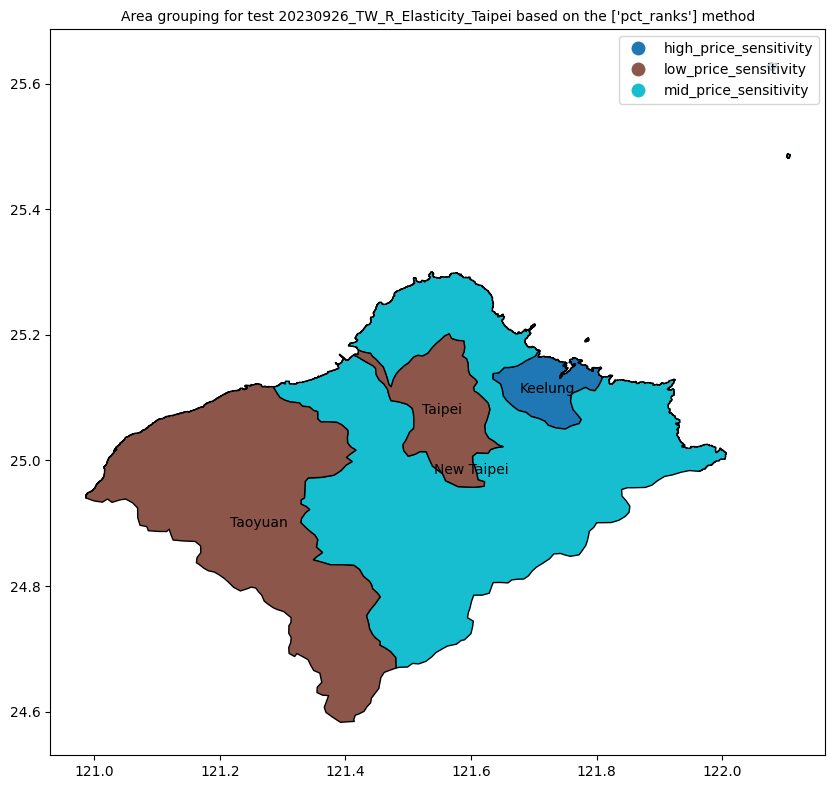

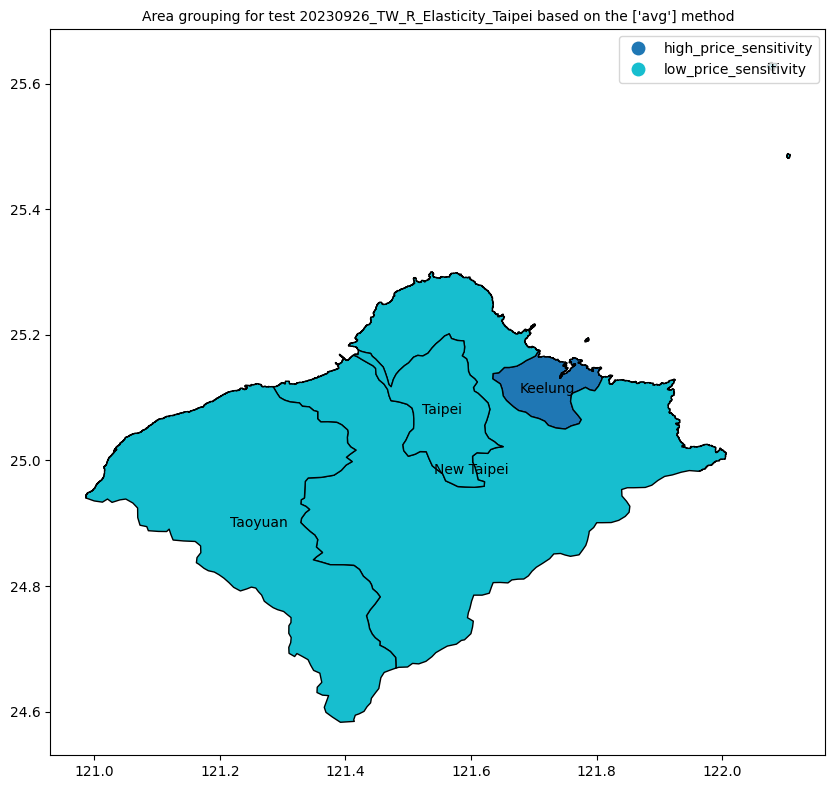

In [44]:
# Plot the color-coded customer location areas per test-grouping method combination
for tst in df_final_area_grouping["test_name"].unique():
    plot_areas(grouping_method_col="area_category_pct_ranks_method", test_name=tst)
    plot_areas(grouping_method_col="area_category_avg_method", test_name=tst)